# Computer Lab 1: k-NN classifier

## Exercise 3 – User localization from RSSI

Consider the following scenario, in which we wish to localize a user employing a non-GPS system  (e.g., in indoor localization). The user holds a transmission device (e.g., a smartphone or other sensor with transmission capabilities). Localization is based on measurements of the Received Signal Strength Indicator (RSSI) from D sensors (base stations) placed in the area in which the localization service is provided. The area is divided into $N_C$ square cells, and localization amounts to identifying the cell in which the user is located.

In a **training stage**, the transmission device is placed in the center of each cell and broadcasts a data packet, and RSSI is measured by each sensor. This yields one measurement, corresponding to a vector of length $D$. The process is repeated $M$ times for each cell, and for all $N_C$ cells. The training stage provides a 3-dimensional array of size $N_C \times D \times M$.

In a **test stage**, the user is located in an unknown cell. The transmission device broadcasts a data packet, and each sensor measures the RSSI and communicates it to a fusion center. The fusion center treats the received RSSI values as a test vector of length $D$. It applies a k-NN classifier, comparing the test vector with all $M \times N_C$ training vectors available in the training set. For each test vector, the k-NN classifier outputs the probability that each cell contains the user.

**Available data**: you are provided with a file (`localization.mat` in `/data/` folder) containing two variables, called traindata and testdata. These variables have the same size, and are 3-dimensional arrays of size $D=7$, $M=5$, and $N_C = 24$.

The training data can be seen as labelled data where each cell is a class, and you are given M data vectors for each cell. Regarding the test data, a test vector consists of a single measurement; so each measurement has to be used individually and you can perform up to M tests for each cell.
The data correspond to real acquisition experiments performed outdoors nearby Politecnico di Torino, using an STM32L microcontroller with 915 MHz 802.15.4 transceiver.

**Task**: your task is to implement a k-NN classifier in Matlab for the classification task described above, and evaluate its performance.

**Performance evaluation**: The performance is defined in terms of accuracy in the localization task, and it has to be averaged over all cells. Average accuracy is defined as the posterior probability associated to the cell that the user is actually located in.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import scipy.io
import seaborn as sns
from tqdm import tqdm

# Plot Seaborn settings
sns.set_context(
    'talk',
    rc = {
        'font.size': 12.0,
        'axes.labelsize': 10.0,
        'axes.titlesize': 10.0,
        'xtick.labelsize': 10.0,
        'ytick.labelsize': 10.0,
        'legend.fontsize': 10.0,
        'legend.title_fontsize': 12.0,
        'patch.linewidth': 2.0
    }
)

## 0. Load data

In [5]:
# Check current folder
os.getcwd()

'/'

In [6]:
path = "/Users/ernestocolacrai/Documents/GitHub/StatisticalLearning/data/"

try:
    # Attempt to load the MATLAB data file .mat
    data = scipy.io.loadmat(path + "localization.mat")

    print(
        f"Data ✓\n"
        f"Data Keys: {data.keys()}"
    )
except:
    print(f"Not found data! ({path})")

Data ✓
Data Keys: dict_keys(['__header__', '__version__', '__globals__', 'cell_coordinates', 'testdata', 'traindata'])


In [7]:
# Check train and test datasets shapes and types

print(
    f"Train dataset shape: \t{data['traindata'].shape}, type: {type(data['traindata'])}\n"
    f"Test dataset shape: \t{data['testdata'].shape}, type: {type(data['testdata'])}"
)

Train dataset shape: 	(7, 5, 24), type: <class 'numpy.ndarray'>
Test dataset shape: 	(7, 5, 24), type: <class 'numpy.ndarray'>


In [8]:
D = 7 # Features number (ROWS)
M = 5 # Measures number for each cell (class) (COLUMNS)
Nc = 24 # Classes number (cells number) (DEPTH)

## 1. Rearrange data

In [9]:
def rearrange(dataset:np.ndarray, rows:int, columns:int, depth:int) -> np.ndarray:
    """
    Reshapes a 3D NumPy array into a flattened 2D array.

    Parameters:
        dataset (numpy.ndarray): A 3D NumPy array representing the input dataset.
        rows (int): The number of rows in the input dataset.
        columns (int): The number of columns in the input dataset.
        depth (int): The number of depth dimensions in the input dataset.

    Returns:
        (numpy.ndarray): The rearranged dataset, represented as a 2-dimensional NumPy array with dimensions of `(columns * depth, rows + 1)`.
    """
    arranged = np.zeros([columns * depth, rows + 1]) # Initialize an empty 2D NumPy array to store the rearranged data
    label = 0 # Multi-class label (1,2,...,24 classes)
    for j in range(depth): # Iterate through the depth
        for i in range(columns): # Iterate through each column
            # Rearrange the data from the input dataset along the depth dimension into a temporary 1D array
            rearranged_data = dataset[:, i, j].T
            arranged[i + label, :-1] = rearranged_data # Append the rearranged data to the `arranged` array
            arranged[i + label, -1] = j + 1 # +1 since it starts from 0
        
        label += columns # Update the label within the `arranged` array
    
    # Return the final rearranged array
    return arranged

In [10]:
# Create the (rearranged) train and test datasets
train_data = rearrange(data['traindata'], D, M, Nc).astype(int)
test_data = rearrange(data['testdata'], D, M, Nc).astype(int)

# Random permutation
train_data = np.random.permutation(train_data)
test_data = np.random.permutation(test_data)

In [11]:
# Check the (rearranged) train and test datasets shapes and types

print(
    f"Train dataset shape: \t{train_data.shape}, type: {type(train_data)}\n"
    f"Test dataset shape: \t{test_data.shape}, type: {type(test_data)}"
)

Train dataset shape: 	(120, 8), type: <class 'numpy.ndarray'>
Test dataset shape: 	(120, 8), type: <class 'numpy.ndarray'>


## 2. kNN classification

In [12]:
k = 3 # Number of nearest-neighboors
bar = True # Show tqdm progress bar

M = len(test_data)
N = len(train_data)

D = np.zeros([M, N], dtype=float)  # Distance matrix
E = np.zeros([M, k], dtype=int)  # Array of nearest neighbors

infer_labels = np.zeros(M, dtype=int) # Inferred labels

for i in tqdm(range(M), colour='green', disable=bar): # For each test point
    for j in range(N): # For each training point
        D[i][j] = np.sqrt(np.sum((test_data[i] - train_data[j]) ** 2)) # Calculate euclidean distance between the points
    # Find indices of k nearest neighbors
    E[i] = np.argsort(D[i])[:k]

    vals, freqs = np.unique(train_data[E[i]][:, -1], return_counts=True)
    infer_labels[i] = vals[np.argmax(freqs)]

In [13]:
np.sum(infer_labels == test_data[:, -1]) / len(test_data)

0.7083333333333334

In [14]:
# Test to return inferred label and non-zero probability for each class
# random.seed(1)
idx = random.randint(0,119) # Select a random istance of dataset

values, frequencies = np.unique(train_data[E[idx]][:,-1], return_counts=True)
total_labels_number = len(train_data[E[idx]][:,-1])
probabilities = np.round(frequencies / total_labels_number, 4)

print(
    f"Values: \t{values}\n"
    f"Frequencies: \t{frequencies}\n"
    f"Probabilities: \t{probabilities}\n\n"
    f"Inferret label (with probability): {values[np.argmax(frequencies)], probabilities[np.argmax(frequencies)]}"
)

Values: 	[10 11]
Frequencies: 	[1 2]
Probabilities: 	[0.3333 0.6667]

Inferret label (with probability): (11, 0.6667)


In [15]:
train_data[E[idx]]

array([[-60, -39, -36, -51, -50, -55, -36,  11],
       [-60, -39, -36, -51, -50, -55, -36,  11],
       [-52, -33, -36, -51, -47, -51, -34,  10]])

$\frac{P(\text{to be at C due to kNN}|y=\text{C})P(y=\text{C})}{P(\text{to be at C due to kNN})}$

## 3. Performance evaluation
### 3.1 Accuracy for the localization task

In [48]:
def knn(train_data:np.ndarray, test_data:np.ndarray, k=3, prog_bar=True) -> np.ndarray:
    # Implement also the case in which we want to return also the probability associated
    M = len(test_data) # Number of test data points
    N = len(train_data) # Number of train data points

    D = np.zeros([M, N], dtype=float)  # Distance matrix: for each test data point (row) respect to each train data point (column)
    E = np.zeros([M, k], dtype=int)  # Array of nearest neighbors of each test data point

    # infer_labels = np.zeros(M, dtype=int) # Inferred labels of each test data point
    # infer_labels = []
    infer_labels = np.zeros(M, dtype=np.ndarray)

    for i in tqdm(range(M), colour='green', disable=prog_bar): # For each test point
        for j in range(N): # For each train point
            D[i][j] = np.sqrt(np.sum((test_data[i] - train_data[j]) ** 2)) # Calculate euclidean distance between the points
        # Find indices of k nearest neighbors
        E[i] = np.argsort(D[i])[:k]
        # `vals`: labels of nearest neighboors
        # `freqs`: frequencies of labels of nearest neighbors
        vals, freqs = np.unique(train_data[E[i]][:, -1], return_counts=True)
        total_labels_number = len(train_data[E[i]][:,-1])
        
        # infer_labels[i] = vals[np.argmax(freqs)]
        # infer_labels.append([vals, np.round(freqs / total_labels_number, 4)])
        infer_labels[i] = np.array([vals, np.round(freqs / total_labels_number, 4)])
        
    return infer_labels

In [71]:
def labels_knn(infer_labels):
    M = len(infer_labels)
    labels = np.zeros(M, dtype=int)
    for i in tqdm(range(M), colour='green', disable=False):
        vals, freqs = infer_labels[i][0], infer_labels[i][1]
        l = vals[np.argmax(freqs)]
        labels[i] = l
    return labels

In [72]:
infer_labels = knn(train_data, test_data, k=3, prog_bar=False)

100%|██████████| 120/120 [00:00<00:00, 1917.64it/s]


In [73]:
infer_labels[0]

array([[23.],
       [ 1.]])

In [77]:
np.sum(labels_knn(infer_labels) == test_data[:, -1]) / len(test_data)

100%|██████████| 120/120 [00:00<00:00, 61665.83it/s]


0.7083333333333334

In [81]:
k_max = 120
k_vals = np.arange(1, k_max, 2)
accuracy = []

for k in tqdm(k_vals, colour='green'):
    infer_labels = knn(train_data, test_data, k=k, prog_bar=True)
    a = np.sum(labels_knn(infer_labels) == test_data[:, -1]) / len(test_data)
    accuracy.append(a)

100%|██████████| 60/60 [00:02<00:00, 23.68it/s]


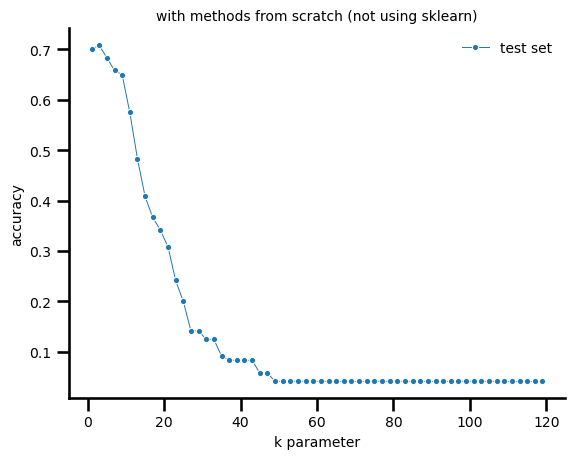

In [93]:
fig, ax = plt.subplots()

sns.lineplot(
    x=k_vals, y=accuracy,
    ax=ax,
    marker='.',
    lw=0.7,
    label=f"test set"
    )

ax.legend(framealpha=0)
ax.set_ylabel("accuracy")
ax.set_xlabel("k parameter")
ax.set_title("with methods from scratch (not using sklearn)")

sns.despine(right=True)